# Homework12

Exercises with Neural Networks

## Goals

- Get familiar with neural network setup, design, data preparation and training process
- Practice setting up the ingredients and parameters for the training loop
- Experiment with neural networks for classification tasks


### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/nn_utils.py
!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/lfw.tar.gz | tar xz

In [2]:
import torch

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from torch import nn, Tensor

from data_utils import classification_error, display_confusion_matrix
from data_utils import LFWUtils

from nn_utils import get_labels

## Neural Networks and Classification

We saw a neural network that performs linear regression in the [WK12](https://github.com/PSAM-5020-2025S-A/WK12) notebook, but, how can we use one for classification ?

The modifications aren't too hard. We first need to have as many output nodes as we have classes in our dataset. If we're trying to classify images into $25$ categories, we need $25$ output neurons.

We also need to use a different kind of loss/cost function that will force the network to only have one activated neuron in its output layer, per input. If we give it data for something that should be classified as class $7$, the neuron that represents class $7$ at the output layer should be activated way more than the others.

### Cross Entropy Loss

The cost of being wrong for a classification network is calculated using a function called *Cross Entropy*. It basically measures how different two distributions are, and in this case, we want to compare the distributions of values from the last layer of our network and what we expected to get at the last layer, over all of the inputs that it was shown.

For example, let's say we are training a classification neural network on a dataset with $3$ classes. The correct distribution of labels in the training dataset is:

| $\text{class}$ | $\text{distribution}$ |
|----|----|
| $0$ | $45\%$ |
| $1$ | $35\%$ |
| $2$ | $20\%$ |

but instead we get the following distribution for the predictions:

| $\text{class}$ | $\text{distribution}$ |
|----|----|
| $0$ | $32\%$ |
| $1$ | $32\%$ |
| $2$ | $36\%$ |

*Cross Entropy* is a way to quantify how different these two distributions are and, hopefully, guide our network parameters to make them more similar.

The actual cost calculation is a sum of how different each prediction is from a "perfect" prediction. For example, if we're trying to classify something as class $0$, we should get output neuron activations that are something like: `[1.0, 0.0, 0.0]`. If instead we get: `[0.5, 0.8, 0.1]`, the *Cross Entropy* contribution for this sample is calculated as:
$$\displaystyle - \log\left(\frac{e^{0.5}}{e^{0.5} + e^{0.8} + e^{0.1}}\right)$$

By using this as the cost function, the neural network can optimize its parameters to increase the value of the first output, while decreasing the values of the other outputs. It doesn't have to get `[1.0, 0.0, 0.0]` exactly, so the network optimizes its parameters to make the first output as different as possible from the others.

Instead of writing our own cost function like we did with the euclidean cost for linear regression, we'll use the built in `CrossEntropyLoss` function in the `PyTorch` library.

### The Process ...

... is the same.

### Start with the Data

As always, we start with the data, and this time put the pixel and label information straight into `Tensor` objects.

In [3]:
train, test = LFWUtils.train_test_split(0.5)

x_train = Tensor(train["pixels"])
y_train = Tensor(train["labels"]).long()

x_test = Tensor(test["pixels"])
y_test = Tensor(test["labels"]).long()

len(x_train), len(x_test)

(445, 438)

### Let's train !

Let's create a single layer neural network, like the one from class, and train it with the training data.

In addition to the actual model/network, we also need an optimizer and a loss function.

In [4]:
# TODO: Create the model and optimizer, the loss function is already defined
# Define the model
class SingleLayerNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SingleLayerNN, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

input_dim = x_train.shape[1]  # number of features (e.g., pixels per image)
num_classes = len(torch.unique(y_train))  # number of unique labels

model = SingleLayerNN(input_dim, num_classes)

loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)

I used Adam because the gradient was exploding and the loss was getting bigger and bigger. Adam adapts the learning rate automatically. 

### The Loop

Create a training loop like we saw in class.

This loop should:
- Predict classes by feeding all of the inputs into the `model`
- Measure `loss` (this is just `loss_fn(predicted, actual)`)
- Get the optimizer to compute gradients
- Update parameters

The loop should be repeated as long as the loss keeps improving, and it doesn't look like the model is overfitting with the training data.

In order to check if the model is overfitting, we can sporadically run evaluations within the training loop in order to see if the model performs similarly with `train` and `test` data.

But ! Our network actually outputs a series of values for each image that we give it. In order to determine the exact class number of its predictions, we have to find the index of the output neuron with the largest value, which is an operation called `argmax()` (similar to `argsort()` from week 10).

It's not hard to do this manually, but we can use the `get_labels(model, inputs)` function inside the `nn_utils` file to run our `model` on all of the data in a given dataset and return the predicted labels for all of the samples.

In [5]:
# TODO: iterate epochs
epochs = 1000
losses = []

for epoch in range(epochs):
    model.train()
    # TODO: predict
    outputs = model(x_train)
    # TODO: measure loss
    loss = loss_fn(outputs, y_train)

    # TODO: compute gradient and step optimizer
    optim.zero_grad()
    loss.backward()
    optim.step()


    # TODO: show progress
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    losses.append(loss.item())


Epoch [1/1000], Loss: 129.0506
Epoch [2/1000], Loss: 143.8104
Epoch [3/1000], Loss: 228.2872
Epoch [4/1000], Loss: 327.3479
Epoch [5/1000], Loss: 420.8883
Epoch [6/1000], Loss: 461.6955
Epoch [7/1000], Loss: 480.1596
Epoch [8/1000], Loss: 552.8503
Epoch [9/1000], Loss: 449.4620
Epoch [10/1000], Loss: 472.0668
Epoch [11/1000], Loss: 513.0571
Epoch [12/1000], Loss: 510.8802
Epoch [13/1000], Loss: 515.8264
Epoch [14/1000], Loss: 534.5052
Epoch [15/1000], Loss: 600.5493
Epoch [16/1000], Loss: 559.2852
Epoch [17/1000], Loss: 503.2169
Epoch [18/1000], Loss: 480.2742
Epoch [19/1000], Loss: 431.7009
Epoch [20/1000], Loss: 349.0853
Epoch [21/1000], Loss: 332.1334
Epoch [22/1000], Loss: 295.7509
Epoch [23/1000], Loss: 289.2101
Epoch [24/1000], Loss: 282.7847
Epoch [25/1000], Loss: 243.9167
Epoch [26/1000], Loss: 234.8072
Epoch [27/1000], Loss: 216.9788
Epoch [28/1000], Loss: 210.2583
Epoch [29/1000], Loss: 199.2083
Epoch [30/1000], Loss: 193.1931
Epoch [31/1000], Loss: 178.4520
Epoch [32/1000], 

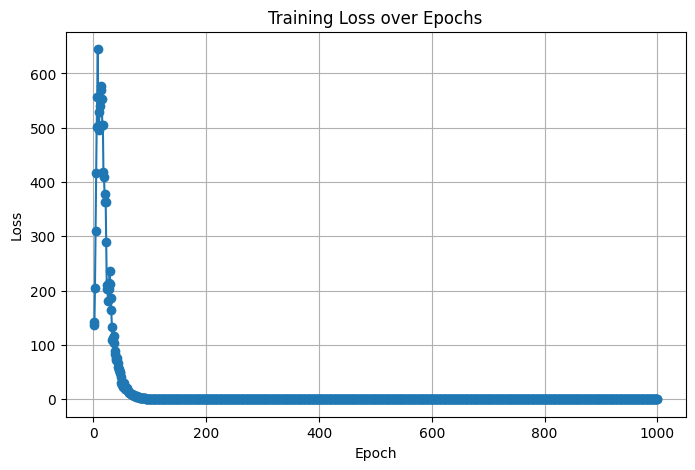

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### Evaluate

This should be similar to the last error values seen during training, but sometimes it changes a bit...

Not a bad idea to check the accuracy of the model using the `classification_error()` function, and look at some confusion matrices.

Classification error: 0.5799


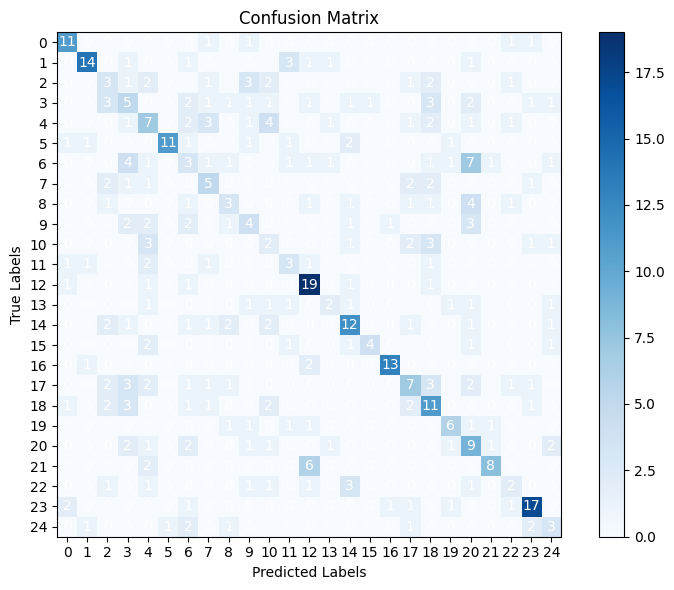

In [20]:
# TODO: classification error for train and test data
# TODO: confusion matrices for train and test data


# Get true and predicted labels
with torch.no_grad():
    outputs = model(x_test)
    _, predicted = torch.max(outputs, 1)
    error = classification_error(y_test, predicted)
    print(f"Classification error: {error:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test.numpy(), predicted.numpy())

# Plot confusion matrix with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(num_classes))
plt.yticks(range(num_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white")

plt.show()


## Neural Networks and PCA

We are seeing how Neural Networks can be _easy_ to build and explain in generic/abstract terms (a bunch of little operators that perform weighted sums of their inputs), but in reality can be really difficult and opaque to steer.

In theory, a couple of well placed neuron layers, with the right hyperparameters, learning rate, loss function, architecture and a good amount of data, can learn to extract information like polynomial features, clusters or even PCA components. But... that's not always the case and sometimes it's not a bad idea to push/bias/encourage the network to go down a certain path.

One way to do this is to pre-process our inputs and do a bit of feature extraction ourselves.

Let's see if we can improve this face classification network by using PCA information instead of pixel data.

### Add PCA

We're going to repeat the training, but this time our data is going to be scaled and PCA'd before going into the neural network.

So, the data preparation flow should be:
- Scale data for `PCA`
- Perform `PCA`

We need one `StandardScaler()` object and one `PCA()` object.

The `train` data goes through the `fit_transform()` function of these objects, while the `test` data only goes through `transform()`.

For the `PCA`, we can aim for an explained variance of $99\%$. This should reduce the number of features significantly to allow us to experiment with our network architecture.

In [6]:
# TODO: Scale
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(train["pixels"])
x_test_scaled = scaler.transform(test["pixels"])
# TODO: PCA
pca = PCA(n_components=100)  # I might choose a smaller number if I see overfitting
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

# TODO: Tensors
x_train = torch.tensor(x_train_pca, dtype=torch.float32)
y_train = torch.tensor(train["labels"]).long()

x_test = torch.tensor(x_test_pca, dtype=torch.float32)
y_test = torch.tensor(test["labels"]).long()

### Repeat

Re-create model, optimizer, loss function, then re-run the training loop and evaluate.

Epoch [1/1000], Loss: 15.3934
Epoch [2/1000], Loss: 15.3503
Epoch [3/1000], Loss: 15.3073
Epoch [4/1000], Loss: 15.2643
Epoch [5/1000], Loss: 15.2213
Epoch [6/1000], Loss: 15.1783
Epoch [7/1000], Loss: 15.1354
Epoch [8/1000], Loss: 15.0926
Epoch [9/1000], Loss: 15.0498
Epoch [10/1000], Loss: 15.0070
Epoch [11/1000], Loss: 14.9643
Epoch [12/1000], Loss: 14.9217
Epoch [13/1000], Loss: 14.8791
Epoch [14/1000], Loss: 14.8365
Epoch [15/1000], Loss: 14.7940
Epoch [16/1000], Loss: 14.7515
Epoch [17/1000], Loss: 14.7091
Epoch [18/1000], Loss: 14.6667
Epoch [19/1000], Loss: 14.6244
Epoch [20/1000], Loss: 14.5822
Epoch [21/1000], Loss: 14.5400
Epoch [22/1000], Loss: 14.4978
Epoch [23/1000], Loss: 14.4557
Epoch [24/1000], Loss: 14.4137
Epoch [25/1000], Loss: 14.3717
Epoch [26/1000], Loss: 14.3298
Epoch [27/1000], Loss: 14.2879
Epoch [28/1000], Loss: 14.2461
Epoch [29/1000], Loss: 14.2043
Epoch [30/1000], Loss: 14.1626
Epoch [31/1000], Loss: 14.1209
Epoch [32/1000], Loss: 14.0793
Epoch [33/1000], 

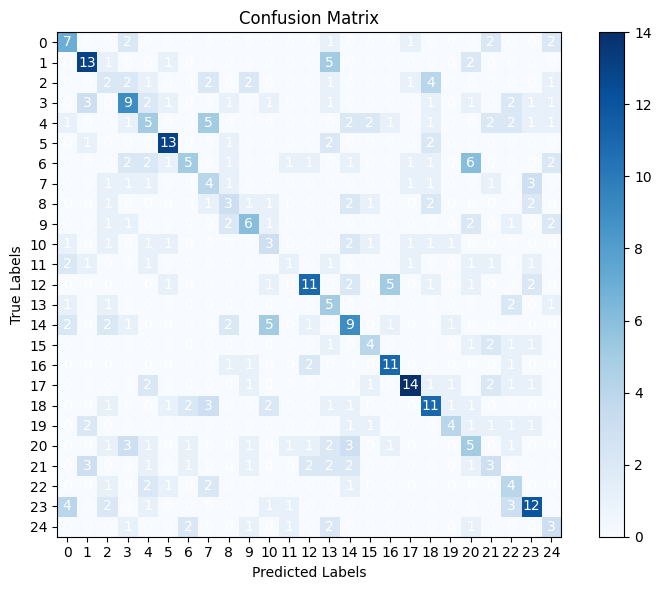

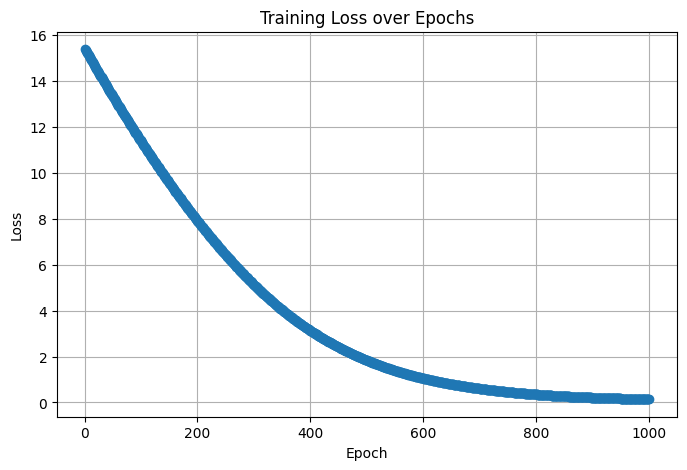

In [8]:
# TODO: Model, Optimizer and Loss Function
class SingleLayerNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SingleLayerNN, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

input_dim = x_train.shape[1]  # number of features (e.g., pixels per image)
num_classes = len(torch.unique(y_train))  # number of unique labels

model = SingleLayerNN(input_dim, num_classes)

loss_fn = nn.CrossEntropyLoss()

optim = torch.optim.Adam(model.parameters(), lr=0.0001)

# TODO: Training loop
epochs = 1000
losses = []

for epoch in range(epochs):
    model.train()
    outputs = model(x_train)
    loss = loss_fn(outputs, y_train)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# TODO: Evaluation
with torch.no_grad():
    outputs = model(x_test)
    _, predicted = torch.max(outputs, 1)

    # Compute classification error
    error = classification_error(y_test, predicted)
    print(f"Classification error: {error:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test.numpy(), predicted.numpy())

# Plot confusion matrix with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(num_classes))
plt.yticks(range(num_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()

# Add text annotations
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white")

plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### Interpretation

<span style="color:hotpink;">
So... What happens ?<br>
How does training on the <code>PCA</code> data compare to training on the regular data ?

What else does <code>PCA</code> afford us in this case ? ...<br>
How does adding extra layers in the original network compare to adding extra layers in the <code>PCA</code> network?
</span>

<span style="color:hotpink;">With regular data, it is easier to get into the fenomenon where the loss function goes to zero before it represents something meaningful in the output, or overfitting. I guess it's gonna be useful to prevent gradient descent and explosion, or oscillations.   </span>